In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import *
from openretina.models.core_readout import load_core_readout_from_remote


# Load model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_core_readout_from_remote(
    "karamanlis_2024_base", device="cuda" if torch.cuda.is_available() else "cpu"
)
model

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# pick a random session
session_id = list(model.readout.keys())[-1]
print(session_id)
n_neurons = model.readout[session_id].outdims
print(f"Number of neurons: {n_neurons}")

20210203_252MEA_mouse_left_half_dorsal


# Load natural images

In [ ]:
movies, n_empty_frames = prepare_movies_dataset(model, session_id, device = device)

Loaded 3191 images with shape: (3191, 864, 864)
Compressed shape: (3191, 60, 80)
Final movies shape: (3191, 1, 26, 60, 80)


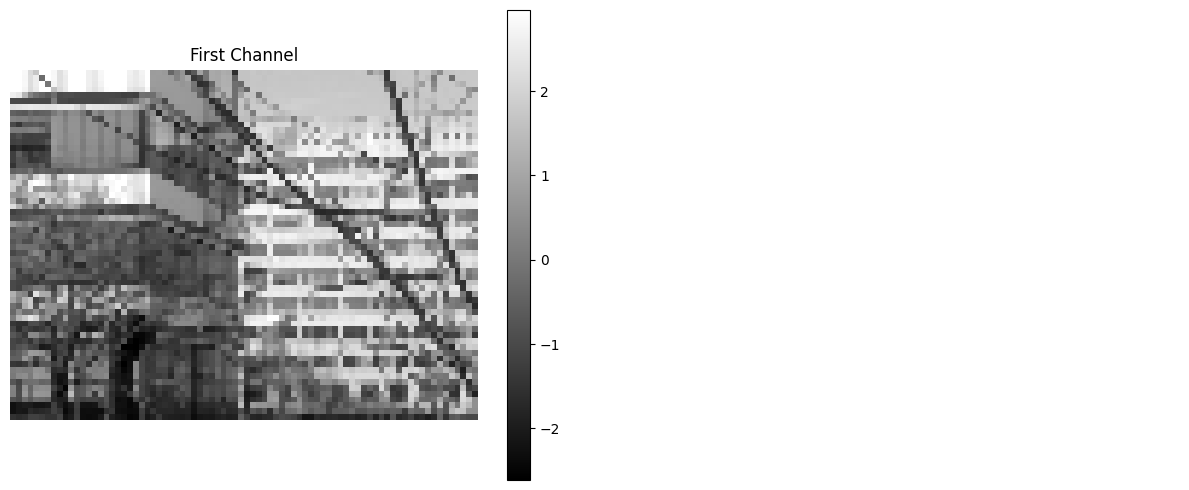

First channel range: [-2.611, 2.962]


In [ ]:
# Display the last frame of an example movie with both channels side by side
example_idx = 0  # First movie as example
last_frame = movies[example_idx, :, -1, :, :]  # Shape: (2, 72, 64)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First channel (channel 0)
im1 = axes[0].imshow(last_frame[0], cmap='grey', vmin=movies[:, 0, :, :].min(), vmax=movies[:, 0, :, :].max())
axes[0].set_title('First Channel')
plt.colorbar(im1, ax=axes[0])
axes[0].axis('off')
# Optional : Second channel (channel 1) 
# im2 = axes[1].imshow(last_frame[1], cmap='Purples', vmin=movies[:, 1, :, :].min(), vmax=movies[:, 1, :, :].max())
# axes[1].set_title('Second Channel')
# # plt.colorbar(im2, ax=axes[1])
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"First channel range: [{last_frame[0].min():.3f}, {last_frame[0].max():.3f}]")
# print(f"Second channel range: [{last_frame[1].min():.3f}, {last_frame[1].max():.3f}]")

In [ ]:
cell_id = 122
lsta_library, response_library = compute_lsta_library(model, movies, session_id, cell_id, batch_size=64, device=device)

Text(0, 0.5, 'Cell predicted Response (au)')

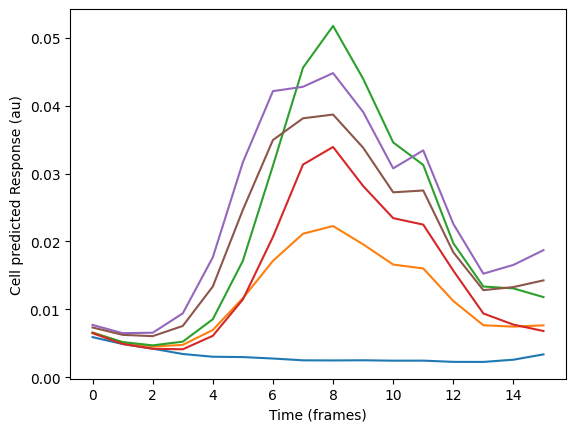

In [ ]:
# We can check some sample responses, making sure the integrity of the response profile is predicted and we did not cut it too short.

plt.plot(response_library[0, :, cell_id])
plt.plot(response_library[1, :, cell_id])
plt.plot(response_library[2, :, cell_id])
plt.plot(response_library[3, :, cell_id])
plt.plot(response_library[4, :, cell_id])
plt.plot(response_library[5, :, cell_id])
plt.xlabel('Time (frames)')
plt.ylabel('Cell predicted Response (au)')

In [ ]:
lsta_library.shape

(1000, 1, 60, 80)

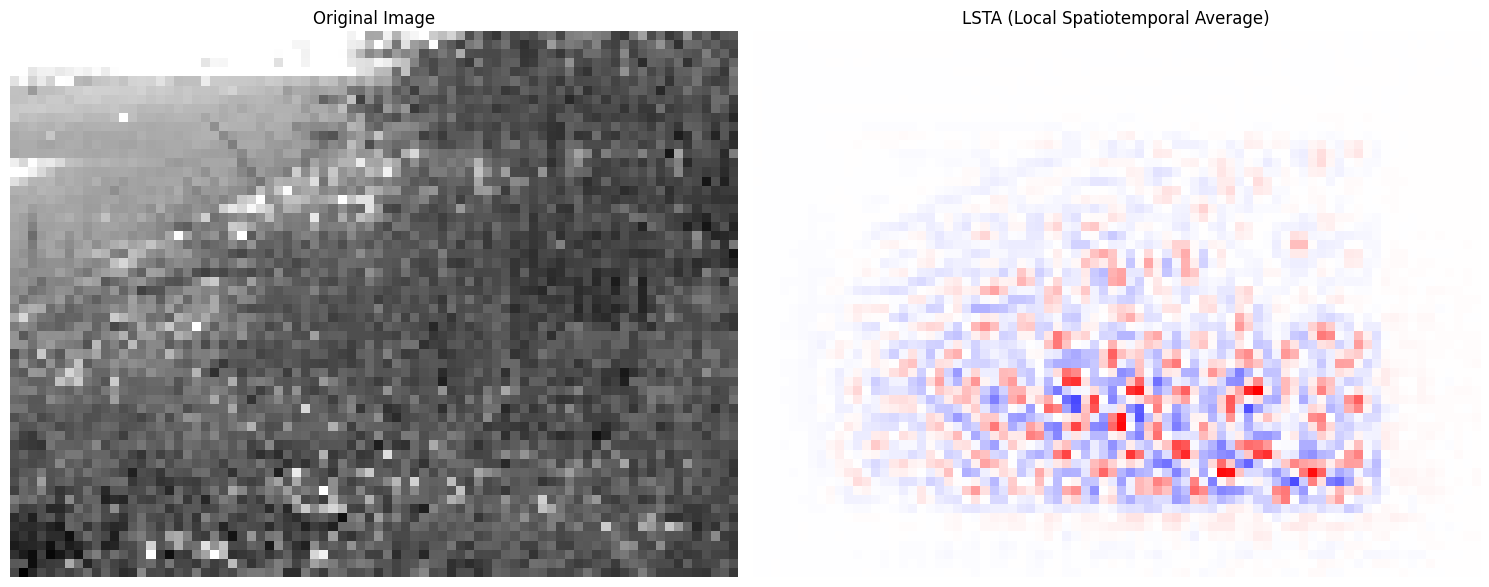

In [ ]:
# We can now plot an example LSTA and the corresponding image

image = 25
channel = 0
lsta = lsta_library[image, channel]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# image
axes[0].imshow(movies[image,0,-1], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# LSTA
axes[1].imshow(lsta, cmap='bwr', vmin=-abs(lsta).max(), vmax=abs(lsta).max())
axes[1].set_title('LSTA (Local Spatiotemporal Average)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Do PCA on the LSTA library

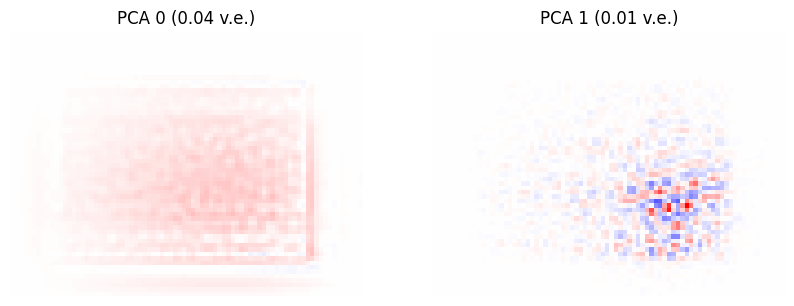

In [ ]:
# Select channel
channel = 0
# lsta_library = lsta_library[:, :, :]

PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)



In [ ]:
# Project the images onto PCA space
images = movies[:,channel,-1,:,:]
images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)

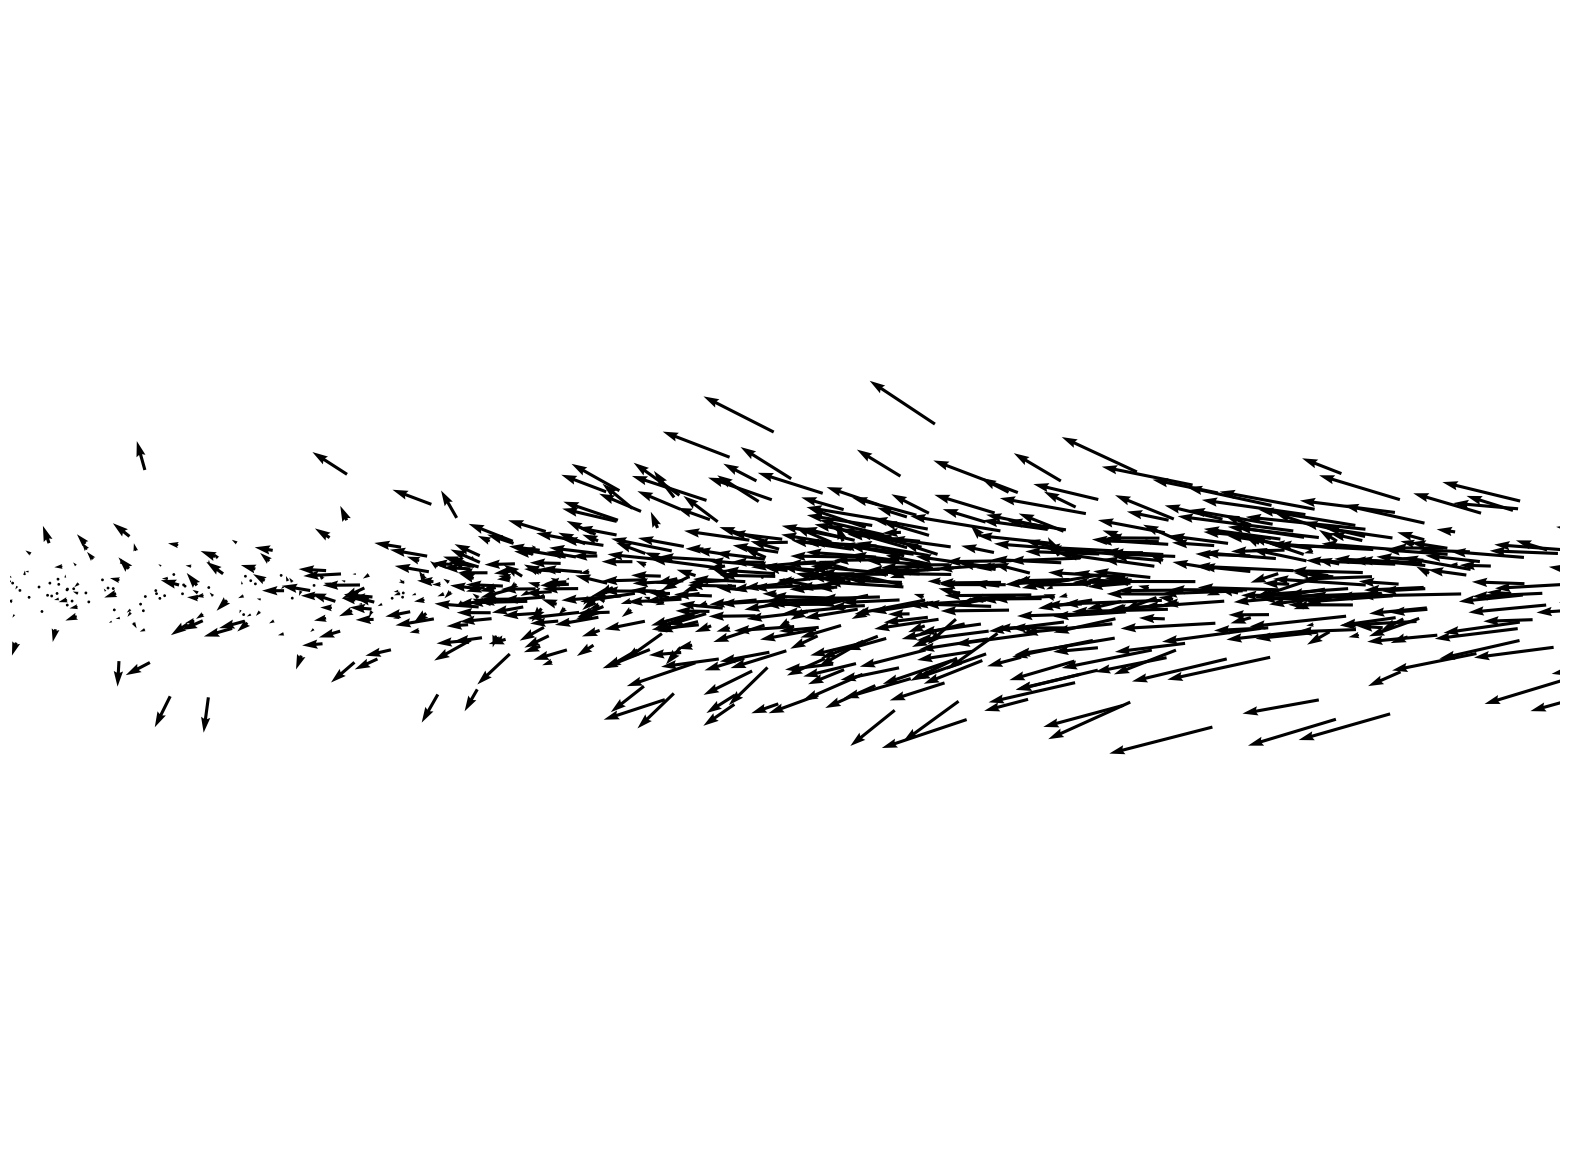

In [ ]:
# Plot the vector field of the LSTA in PCA space
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_untreated_vectorfield

fig = plot_untreated_vectorfield(lsta_library, PC1, PC2, images_coordinate)

0.0002338289839103657


/tmp/ipykernel_491293/2031379.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


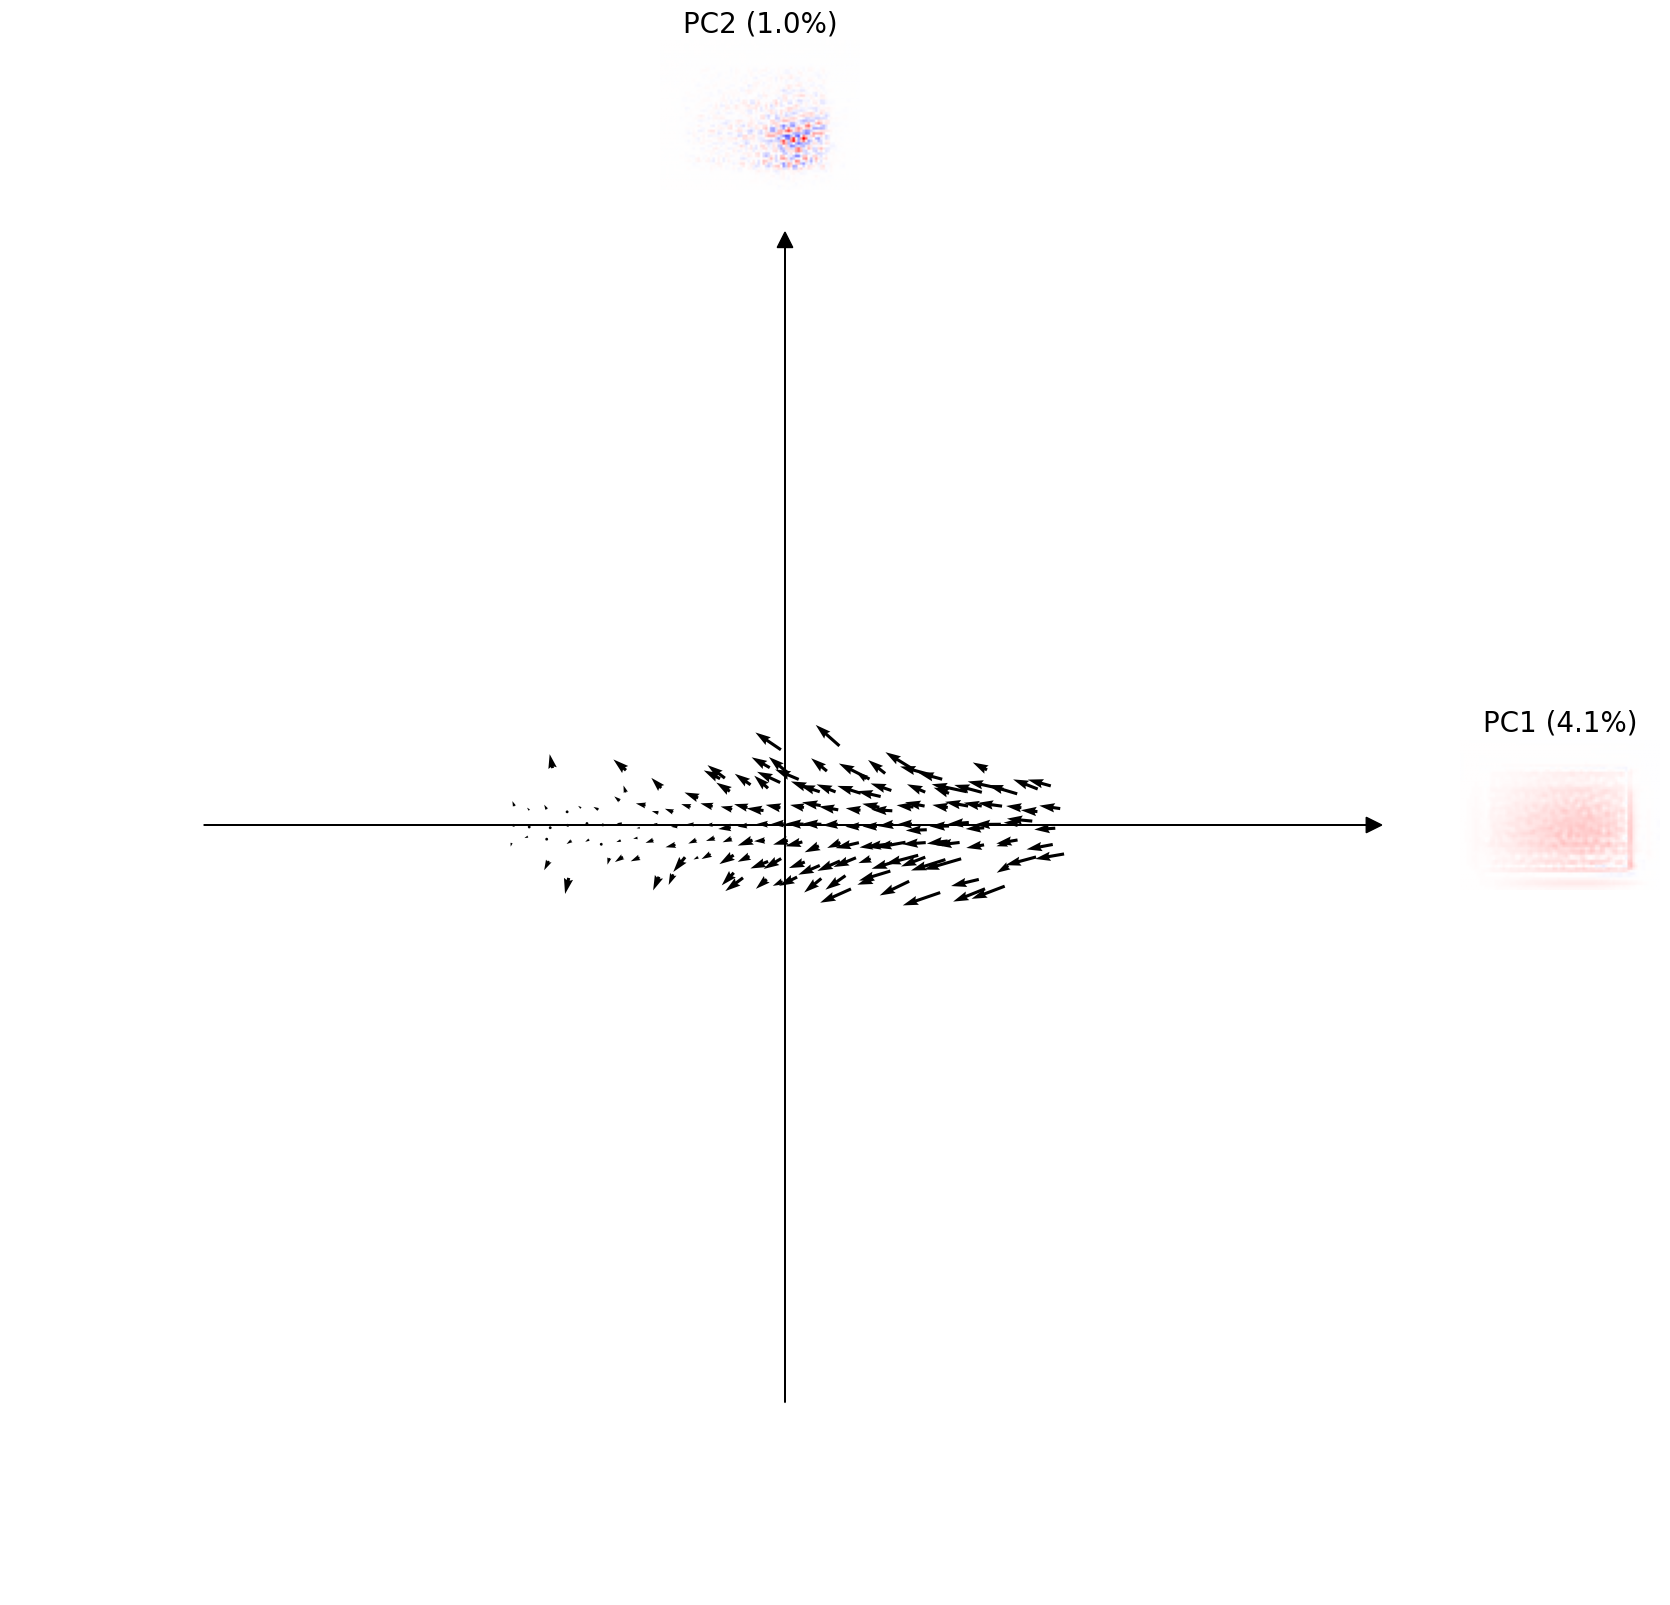

In [ ]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield
fig = plot_clean_vectorfield(
    lsta_library,
    channel,
    PC1,
    PC2,
    images,
    images_coordinate,
    explained_variance,
    x_bins=31,
    y_bins=31,
)
fig.show()

# Create all arrowplots of a session

In [ ]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield


for cell_id in range(n_neurons):
    print(f"Processing cell {cell_id}...")
    lsta_library, response_library = compute_lsta_library(model, movies, session_id, cell_id, batch_size=64, device=device)
    PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)
    images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)
    fig = plot_clean_vectorfield(
        lsta_library,
        channel,
        PC1,
        PC2,
        images,
        images_coordinate,
        explained_variance,
        x_bins=31,
        y_bins=31,
    )
    fig.savefig(f"karamanlis_vector_fields/cell_{cell_id}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

Processing cell 0...
0.07869517483258096
Processing cell 1...
0.007556395061073556
Processing cell 2...
0.06731129731672995
Processing cell 3...
0.000444211412750569
Processing cell 4...
0.0007481398331637664
Processing cell 5...
0.0413321052106436
Processing cell 6...
0.017031809333862384
Processing cell 7...
0.0008048264250559703
Processing cell 8...
0.033064989120083675
Processing cell 9...
0.12889046125382722
Processing cell 10...
0.06919326460090312
Processing cell 11...
0.03089815932922567
Processing cell 12...
0.016862208848125924
Processing cell 13...
0.04347412966755182
Processing cell 14...
0.032562130745930846
Processing cell 15...
0.024830801977245763
Processing cell 16...
0.0013245588770501703
Processing cell 17...
0.001983241210568294
Processing cell 18...
0.08696285091033393
Processing cell 19...
0.013701074082074396


<string>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Processing cell 20...


/home/baptiste/Documents/LabPipelines/open-retina/openretina/insilico/VectorFieldAnalysis/vector_field_analysis.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


0.0002942027651395865
Processing cell 21...
0.0017128028043926725
Processing cell 22...
0.00033075116974458634
Processing cell 23...
8.43272920104115e-06
Processing cell 24...
0.001880220589186321
Processing cell 25...
0.05843495464538702
Processing cell 26...
0.05434301422631249
Processing cell 27...
0.00017310177585761404
Processing cell 28...
0.019863596139917075
Processing cell 29...
0.011557077613236823
Processing cell 30...
0.025886396882516573
Processing cell 31...
0.03479455057176227
Processing cell 32...
0.013004207316514813
Processing cell 33...
0.08627065750029317
Processing cell 34...
0.01643590451814258
Processing cell 35...
0.0025954086047952807
Processing cell 36...
8.481717828231044e-06
Processing cell 37...
0.02127135160220639
Processing cell 38...
0.0016205027565084208
Processing cell 39...
0.001507574097618676
Processing cell 40...
0.02871849414846017
Processing cell 41...
0.0011118040241000146
Processing cell 42...
0.07025379238608595
Processing cell 43...
0.0002519